In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"C:\Users\Laptop World\Desktop\NLPPROJECT\train_cleaned_with_sentences.csv"
df = pd.read_csv(file_path)

print(f"Loaded {len(df):,} descriptions")
print("Columns:", df.columns.tolist())

Loaded 120,000 descriptions
Columns: ['Class Index', 'Clean_Title', 'Clean_Sentences']


In [3]:
df

,Class Index,Clean_Title,Clean_Sentences
0,3,wall st bear claw back black reuters,['reuters shortsellers wall street dwindlingba...
1,3,carlyle look toward commercial aerospace reuters,['reuters private investment firm carlyle grou...
2,3,oil economy cloud stock outlook reuters,['reuters soaring crude price plus worriesabou...
3,3,iraq halt oil export main southern pipeline re...,['reuters authority halted oil exportflows mai...
4,3,oil price soar alltime record posing new menac...,['afp tearaway world oil price toppling record...
...,...,...,...
119995,1,pakistan musharraf say wont quit army chief,['karachi reuters pakistani president pervez m...
119996,2,renteria signing topshelf deal,['red sox general manager theo epstein acknowl...
119997,2,saban going dolphin yet,['miami dolphin put courtship lsu coach nick s...
119998,2,today nfl game,['pittsburgh ny giant time pm line steelers re...


In [4]:
# Convert Clean_Sentences to List + Flatten

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df['Sentences_List'] = df['Clean_Sentences'].apply(safe_eval)

In [5]:
data = []
for idx, row in df.iterrows():
    for sent in row['Sentences_List']:
        if isinstance(sent, str):
            sent = sent.strip()
            if len(sent.split()) >= 2:  # At least 2 words for Bigram
                data.append({
                    'Sentence': sent,
                    'Label': row['Class Index']  # 1=World, 2=Sports, 3=Business, 4=Sci/Tech
                })

data_df = pd.DataFrame(data)
print(f"Total usable sentences: {len(data_df):,}")

Total usable sentences: 151,130


In [6]:
df

,Class Index,Clean_Title,Clean_Sentences,Sentences_List
0,3,wall st bear claw back black reuters,['reuters shortsellers wall street dwindlingba...,[reuters shortsellers wall street dwindlingban...
1,3,carlyle look toward commercial aerospace reuters,['reuters private investment firm carlyle grou...,[reuters private investment firm carlyle group...
2,3,oil economy cloud stock outlook reuters,['reuters soaring crude price plus worriesabou...,[reuters soaring crude price plus worriesabout...
3,3,iraq halt oil export main southern pipeline re...,['reuters authority halted oil exportflows mai...,[reuters authority halted oil exportflows main...
4,3,oil price soar alltime record posing new menac...,['afp tearaway world oil price toppling record...,[afp tearaway world oil price toppling record ...
...,...,...,...,...
119995,1,pakistan musharraf say wont quit army chief,['karachi reuters pakistani president pervez m...,[karachi reuters pakistani president pervez mu...
119996,2,renteria signing topshelf deal,['red sox general manager theo epstein acknowl...,[red sox general manager theo epstein acknowle...
119997,2,saban going dolphin yet,['miami dolphin put courtship lsu coach nick s...,[miami dolphin put courtship lsu coach nick sa...
119998,2,today nfl game,['pittsburgh ny giant time pm line steelers re...,[pittsburgh ny giant time pm line steelers rec...


In [16]:
X = data_df['Sentence']
y = data_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keep class balance
)

print(f"Train sentences: {len(X_train):,}")
print(f"Test sentences: {len(X_test):,}")

Train sentences: 120,904
Test sentences: 30,226


In [28]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Unigram, Bigram, Trigram
    lowercase=True,
    stop_words='english',
    max_features=100000,
    min_df=2,
    max_df=0.95
)

# Fit on Train only
vectorizer.fit(X_train)


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [29]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Train vector shape: {X_train_vec.shape}")
print(f"Test vector shape: {X_test_vec.shape}")

Train vector shape: (120904, 100000)
Test vector shape: (30226, 100000)


In [30]:
# Train Naive Bayes on Train
# ========================================
clf = MultinomialNB(alpha=1.0)  # Laplace Smoothing

clf.fit(X_train_vec, y_train)
print("Naive Bayes trained!")

Naive Bayes trained!


In [31]:
y_pred = clf.predict(X_test_vec)

In [32]:
# Evaluate Results
# ========================================
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.1%}")






Accuracy: 87.7%


In [33]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))


Classification Report:
              precision    recall  f1-score   support

       World       0.90      0.86      0.88      6968
      Sports       0.91      0.96      0.93      8256
    Business       0.86      0.81      0.83      7001
    Sci/Tech       0.83      0.87      0.85      8001

    accuracy                           0.88     30226
   macro avg       0.88      0.87      0.87     30226
weighted avg       0.88      0.88      0.88     30226



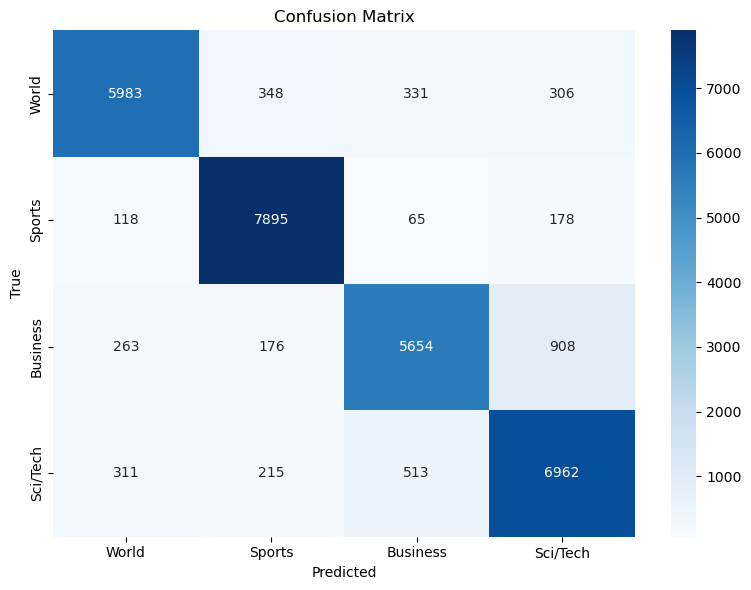

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [35]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(clf, 'nb_classifier.pkl')
print("Vectorizer saved → tfidf_vectorizer.pkl")
print("Model saved → nb_classifier.pkl")

Vectorizer saved → tfidf_vectorizer.pkl
Model saved → nb_classifier.pkl


In [36]:
vectorizer = joblib.load(r"C:\Users\Laptop World\Desktop\NLPPROJECT\tfidf_vectorizer.pkl")
nb_model   = joblib.load(r"C:\Users\Laptop World\Desktop\NLPPROJECT\nb_classifier.pkl")

In [42]:
import re
import string
import random

In [43]:
test_path = r"C:\Users\Laptop World\Desktop\NLPPROJECT\test.csv"
test_df = pd.read_csv(test_path)

print(f"Test dataset loaded: {len(test_df):,} samples")
print(f"Columns: {list(test_df.columns)}\n")

Test dataset loaded: 7,600 samples
Columns: ['Class Index', 'Title', 'Description']



In [45]:

def preprocess_text(text: str) -> str:
    """
    Apply the exact same preprocessing used during training.
    Steps:
        - Lowercase
        - Remove URLs, emails, numbers
        - Remove punctuation
        - Normalize whitespace
    """
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)        # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)               # Remove emails
    text = re.sub(r'\d+', '', text)                   # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()          # Normalize spaces
    return text

# Apply preprocessing
test_df['cleaned'] = test_df['Description'].apply(preprocess_text)
X_test = test_df['cleaned']
y_test = test_df['Class Index']

print(f"Preprocessing complete.\n")

Preprocessing complete.



In [46]:
X_vec = vectorizer.transform(X_test)      # Convert to TF-IDF matrix
y_pred = nb_model.predict(X_vec)          # Predict using Naive Bayes
print("Prediction complete.\n")

Prediction complete.



In [47]:
accuracy = accuracy_score(y_test, y_pred)
print("="*60)
print(f"OVERALL ACCURACY: {accuracy:.1%}")
print("="*60)


OVERALL ACCURACY: 89.0%


In [48]:
# Classification Report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_test, y_pred,
    target_names=['World', 'Sports', 'Business', 'Sci/Tech']
))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       World       0.91      0.88      0.90      1900
      Sports       0.93      0.97      0.95      1900
    Business       0.88      0.82      0.85      1900
    Sci/Tech       0.84      0.89      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



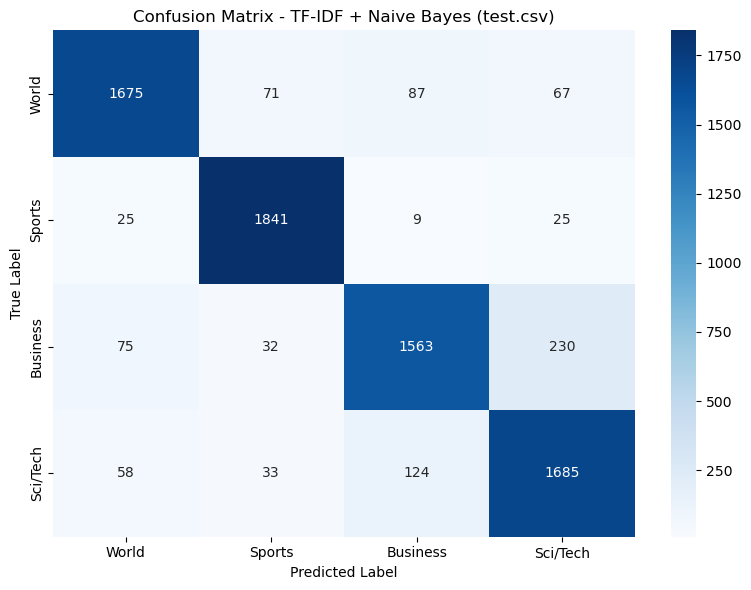

In [49]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
    yticklabels=['World', 'Sports', 'Business', 'Sci/Tech']
)
plt.title('Confusion Matrix - TF-IDF + Naive Bayes (test.csv)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [50]:
random.seed(42)
random_indices = random.sample(range(len(test_df)), 10)

print("\n" + "="*100)
print("10 RANDOM TEST CASES")
print("="*100)
print(f"{'#':<3} {'True':<10} {'Pred':<10} {'Correct':<8} {'Description'}")
print("-"*100)

random_correct = 0
for i, idx in enumerate(random_indices, 1):
    true_label = y_test.iloc[idx]
    pred_label = y_pred[idx]
    true_name = ['World', 'Sports', 'Business', 'Sci/Tech'][true_label - 1]
    pred_name = ['World', 'Sports', 'Business', 'Sci/Tech'][pred_label - 1]
    status = "Yes" if true_label == pred_label else "No"
    if status == "Yes": random_correct += 1
    
    desc = test_df['Description'].iloc[idx]
    short_desc = desc[:70] + "..." if len(desc) > 70 else desc
    
    print(f"{i:<3} {true_name:<10} {pred_name:<10} {status:<8} {short_desc}")

print("-"*100)
print(f"Random Sample Accuracy: {random_correct/10:.0%}")
print("="*100)


10 RANDOM TEST CASES
#   True       Pred       Correct  Description
----------------------------------------------------------------------------------------------------
1   Sci/Tech   Sci/Tech   Yes      washingtonpost.com - First Apple put some color on the iPod, when it o...
2   Sci/Tech   Sports     No       AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday a...
3   Sports     Sports     Yes      AP - Trying to get the best possible ballpark deal for the Montreal Ex...
4   Business   Business   Yes      German Finance Minister Eichel called for the euro #39;s  quot;brutal ...
5   Business   Sci/Tech   No       Vodafone has unveiled plans for 10 new third-generation handsets for C...
6   Sci/Tech   Business   No       Apple's latest Form 10-K filing with the Securities and Exchange Commi...
7   World      World      Yes      For the first time in 41 years, Saudi Arabia is allowing local electio...
8   Business   Business   Yes      T amp;T Wireless Services Inc., 

In [51]:
hand_picked_cases = [
    # Business
    ("Apple launches iPhone 16 with AI and 5G support.", 3),
    ("Oil prices surge after OPEC cuts production by 1M barrels.", 3),
    ("Tesla stock jumps 10% after strong Q4 earnings report.", 3),
    
    # Sports
    ("Real Madrid defeats Barcelona 3-1 in El Clasico.", 2),
    ("Serena Williams wins her 24th Grand Slam title.", 2),
    ("Olympics 2024: USA leads medal tally with 39 golds.", 2),
    
    # Sci/Tech
    ("NASA's Perseverance rover finds signs of ancient life on Mars.", 4),
    ("Google releases Gemini 2.0, outperforms GPT-5.", 4),
    ("Quantum computing breakthrough: 1000-qubit processor unveiled.", 4),
    
    # World
    ("UN Security Council holds emergency meeting on Ukraine crisis.", 1),
    ("Earthquake hits Turkey-Syria border, 7.8 magnitude.", 1),
    ("Climate summit in Paris sets new carbon emission targets.", 1),
    
    # Edge Cases (Mixed / Ambiguous)
    ("Amazon to enter sports streaming with NFL deal.", 3),  # Business or Sports?
    ("AI predicts World Cup winner with 87% accuracy.", 4),   # Sci/Tech or Sports?
    ("Bitcoin hits $100K after US election results.", 3),    # Business + World
]

print("\n" + "="*100)
print("10 HAND-PICKED TEST CASES (Diverse & Challenging)")
print("="*100)
print(f"{'#':<3} {'True':<10} {'Pred':<10} {'Correct':<8} {'Input Text'}")
print("-"*100)

hand_correct = 0
for i, (text, true_label) in enumerate(hand_picked_cases, 1):
    cleaned = preprocess_text(text)
    vec = vectorizer.transform([cleaned])
    pred_label = nb_model.predict(vec)[0]
    true_name = ['World', 'Sports', 'Business', 'Sci/Tech'][true_label - 1]
    pred_name = ['World', 'Sports', 'Business', 'Sci/Tech'][pred_label - 1]
    status = "Yes" if true_label == pred_label else "No"
    if status == "Yes": hand_correct += 1
    
    short_text = text[:60] + "..." if len(text) > 60 else text
    print(f"{i:<3} {true_name:<10} {pred_name:<10} {status:<8} {short_text}")

print("-"*100)
print(f"Hand-Picked Accuracy: {hand_correct/len(hand_picked_cases):.0%}")
print("="*100)


10 HAND-PICKED TEST CASES (Diverse & Challenging)
#   True       Pred       Correct  Input Text
----------------------------------------------------------------------------------------------------
1   Business   Sci/Tech   No       Apple launches iPhone 16 with AI and 5G support.
2   Business   Business   Yes      Oil prices surge after OPEC cuts production by 1M barrels.
3   Business   Business   Yes      Tesla stock jumps 10% after strong Q4 earnings report.
4   Sports     Sports     Yes      Real Madrid defeats Barcelona 3-1 in El Clasico.
5   Sports     Sports     Yes      Serena Williams wins her 24th Grand Slam title.
6   Sports     Sports     Yes      Olympics 2024: USA leads medal tally with 39 golds.
7   Sci/Tech   Sci/Tech   Yes      NASA's Perseverance rover finds signs of ancient life on Mar...
8   Sci/Tech   Sci/Tech   Yes      Google releases Gemini 2.0, outperforms GPT-5.
9   Sci/Tech   Sci/Tech   Yes      Quantum computing breakthrough: 1000-qubit processor unveile...
